In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import cvxopt
import yfinance as yf
import pypfopt
from pypfopt import risk_models
from pypfopt import plotting
from pypfopt import expected_returns
from pypfopt import EfficientFrontier
from pypfopt import DiscreteAllocation
from pypfopt import objective_functions
from sklearn.ensemble import RandomForestRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.model_selection import train_test_split
from pypfopt.discrete_allocation import DiscreteAllocation, get_latest_prices
from sklearn.svm import SVR
from sklearn.preprocessing import MinMaxScaler
import datetime

In [2]:
def getStockPrice(s, lastYearMore = False):
    end_date = pd.Timestamp.now()
    start_date = end_date - pd.DateOffset(years=5)
    raw = yf.download(s, start=start_date, end=end_date)
    p = raw["Adj Close"].dropna(how="all")
    # Add cash into the dataset

    # Copy last year data to achieve 1.5x weight
    # Add weights
    if lastYearMore:
        recent_year = end_date - pd.DateOffset(years=1)
        recent_data = p[p.index >= recent_year]
        weighted_prices = pd.concat([p, recent_data, recent_data * 0.5])
        return weighted_prices.dropna()

    return p.dropna()

def predict(prices, model="RF"):
    if isinstance(prices, pd.Series):
        prices = prices.to_frame()
    # For each stock, create a Random Forest model and predict the price for next 20 days
    predicted_prices = pd.DataFrame(index=range(len(prices.index) + 20))
    predicted_changes = pd.Series(index=prices.columns)
    confidence_values = pd.Series(index=prices.columns)
    for s in prices.columns:
        X = np.array(range(len(prices[s]))).reshape(-1, 1)
        y = prices[s].values
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

        if model == 'RF':
            estimator  = RandomForestRegressor(max_depth=2, random_state=0)
        elif model == 'SVM':
            estimator = SVR(kernel='rbf')
        elif model == 'DT':
            estimator = DecisionTreeRegressor(max_depth=2, random_state=0)
        else:
            raise ValueError(f"Unknown model: {model}")

        estimator.fit(X_train, y_train)

        # Predict for next 20 days
        future = np.array(range(len(prices[s]), len(prices[s]) + 20)).reshape(-1, 1)
        for day in future:
            X_day = day.reshape(1, -1)
            predicted = estimator.predict(X_day)
            y = np.concatenate((y, predicted))
            X = np.concatenate((X, X_day))
            estimator.fit(X, y)  # retrain the model with the predicted value
        predicted_prices[s] = y
        change = (y[-1] - y[-21]) / y[-21]
        predicted_changes[s] = change
    return predicted_prices, predicted_changes


In [3]:
stocks = ['PFE', 'COST', 'AMZN', 'GOOGL', 'MRK', 'TSLA', 'LMT', 'BSX', 'HSBC', 'MSFT', 'SEDG', 'CVX', 'MCD', 'AAPL', 'GS', 'CI', 'NVDA']
stock_prices = getStockPrice(stocks, lastYearMore=True)
index = ['^SPX']
index_price = getStockPrice(index)

[*********************100%***********************]  17 of 17 completed
[*********************100%***********************]  1 of 1 completed


In [4]:
p_price, p_change = predict(stock_prices, model="RF")
p_price_index, p_change_index = predict(index_price, model="RF")

In [5]:
betas = {}
for stock in stocks:
    stock_data = p_price[stock].drop_duplicates()
    index_data = p_price_index.drop_duplicates()

    # 对齐数据
    stock_data, index_data = stock_data.align(index_data, join='inner')

    # 再次确保没有重复的时间戳
    merged_data = pd.concat([stock_data, index_data], axis=1).drop_duplicates()

    returns = merged_data.pct_change().dropna()
    beta = returns.cov().iloc[0, 1] / returns.iloc[:, 1].var()
    betas[stock] = beta

expected_return_index = index_price.pct_change().mean()
rf_rate = 0.0371

In [6]:
m = {stock: rf_rate + beta * (expected_return_index - rf_rate) for stock, beta in betas.items()}
m = pd.Series(m)
S = risk_models.sample_cov(stock_prices)
ef = EfficientFrontier(m, S)
ef.add_constraint(lambda w: w <= 0.10)
ef.add_constraint(lambda w: w >= 0.05)
ef.min_volatility()
weights = ef.clean_weights()
weights

OrderedDict([('PFE', 0.05),
             ('COST', 0.05),
             ('AMZN', 0.05),
             ('GOOGL', 0.05),
             ('MRK', 0.05),
             ('TSLA', 0.05),
             ('LMT', 0.05),
             ('BSX', 0.05),
             ('HSBC', 0.05),
             ('MSFT', 0.1),
             ('SEDG', 0.05),
             ('CVX', 0.1),
             ('MCD', 0.05),
             ('AAPL', 0.05),
             ('GS', 0.1),
             ('CI', 0.05),
             ('NVDA', 0.05)])

In [7]:
expected_return, volatility, sharpe_ratio = ef.portfolio_performance(verbose=False)
sharpe_ratio

-0.0690098359705873

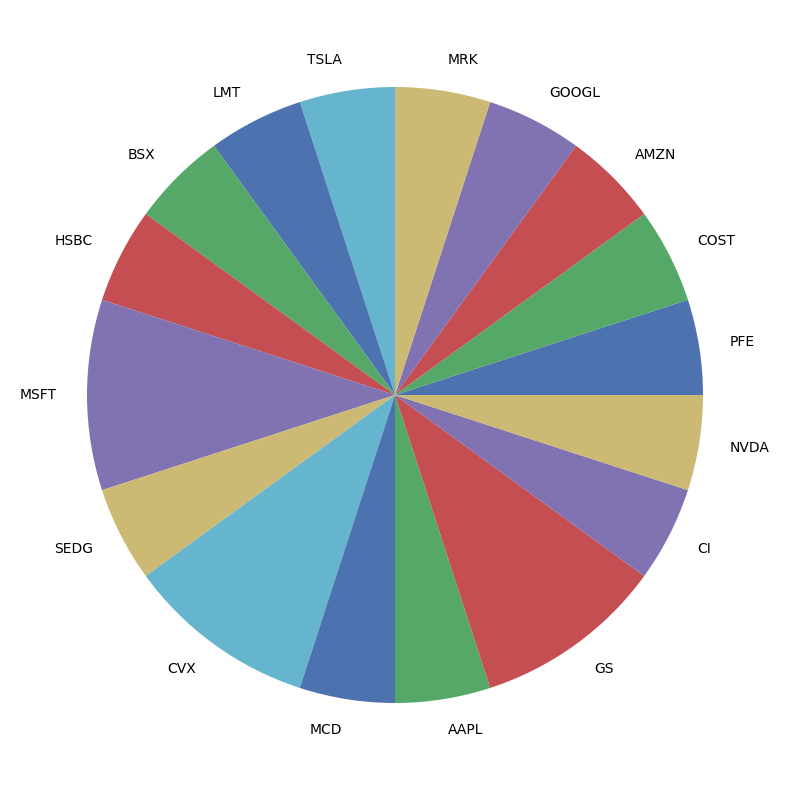

In [8]:
pd.Series(weights).plot.pie(figsize=(10,10));